# Predicting CO2 Emissions Trends: Assessing the Impact of CarbonTax Policy

프로젝트 개요: 

이 프로젝트를 통해 탄소세를 도입한 국가의 CO2 배출량 데이터를 기반으로 모델을 학습하여, 아직 탄소세 정책을 도입하지 않은 국가의 CO2 배출량을 예측함으로써, 탄소세 도입 시 예상되는 CO2 배출 저감 효과를 분석하고자 합니다.

데이터 출처: OECD, IED

시계열 데이터: CO2 emissions, GDP per capita, CO2 emissions by sectors, corporate investment, industrial production, primary energy consumption

예측 모델: Exponential Smoothing, SARIMAX

In [13]:
cd/Users/yeji-park/Downloads/Time_Series_Analysis_CO2/Datasets

/Users/yeji-park/Downloads/Time_Series_Analysis_CO2/Datasets


In [14]:
# Libraries 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

## Datasets & Data Pre-processing

In [15]:
time = 1950 

In [16]:
# GDP in current us($)

gdp = pd.read_csv('gdp_per_capita.csv', skiprows=3)

gdp.drop(labels = ["Country Code", "Indicator Code"], axis = 1, inplace = True)
gdp.rename(columns = {'Country Name':"Country", "Indicator Name":'Indicator'}, inplace = True)

# Filter out the 'Unnamed: 67' column
gdp = gdp.loc[:, ~gdp.columns.str.startswith('Unnamed')]

# Melt the DataFrame to reshape it
gdp = gdp.melt(id_vars=['Country', 'Indicator'], var_name='Year', value_name='GDP')

# Filter out rows where Indicator is not 'GDP per capita (current US$)'
gdp = gdp[gdp['Indicator'] == 'GDP per capita (current US$)']

# Drop the 'Indicator' column
gdp.drop(columns=['Indicator'], inplace=True)

# Convert 'Year' column to integer type
gdp['Year'] = gdp['Year'].astype(int)

gdp.dropna(subset=['GDP'], inplace=True)

gdp.reset_index(drop=True, inplace=True)

gdp = gdp[gdp['Year'] > time]
gdp

,Country,Year,GDP
0,Africa Eastern and Southern,1960,141.385955
1,Afghanistan,1960,62.369375
2,Africa Western and Central,1960,107.053706
3,Australia,1960,1810.597443
4,Austria,1960,935.460427
...,...,...,...
13199,Kosovo,2022,5340.268798
13200,"Yemen, Rep.",2022,650.272218
13201,South Africa,2022,6766.481254
13202,Zambia,2022,1456.901570


In [17]:
# CO2 Emissions by Sectors

co2_sector = pd.read_csv('co-emissions-by-sector.csv')
co2_sector.rename(columns = {'Entity':"Country", "Carbon dioxide emissions from buildings":"Buildings",
                      "Carbon dioxide emissions from industry":"Industry",
                      "Carbon dioxide emissions from land use change and forestry":"Land use change and Forestry",
                      "Carbon dioxide emissions from other fuel combustion": "Other Fuel Combustion",
                      "Carbon dioxide emissions from transport":"Transport",
                      "Carbon dioxide emissions from manufacturing and construction":"Manufacturing and Construction",
                      "Fugitive emissions of carbon dioxide from energy production":"Energy Production",
                      "Carbon dioxide emissions from electricity and heat": "Electricity and Heat"}, inplace = True)
co2_sector.drop(labels = ["Code"], axis = 1, inplace = True)

co2_sector = co2_sector[co2_sector['Year'] > time]
co2_sector

,Country,Year,Buildings,Industry,Land use change and Forestry,Other Fuel Combustion,Transport,Manufacturing and Construction,Energy Production,Electricity and Heat
0,Afghanistan,1990,129999.99,50000.0,-2390000.0,0.0,980000.0,570000.0,NaN,320000.0
1,Afghanistan,1991,140000.00,50000.0,-2390000.0,0.0,930000.0,530000.0,NaN,300000.0
2,Afghanistan,1992,150000.00,50000.0,-2390000.0,0.0,740000.0,390000.0,NaN,200000.0
3,Afghanistan,1993,160000.00,50000.0,-2390000.0,0.0,740000.0,380000.0,NaN,200000.0
4,Afghanistan,1994,160000.00,50000.0,-2390000.0,0.0,730000.0,360000.0,NaN,190000.0
...,...,...,...,...,...,...,...,...,...,...
6350,Zimbabwe,2016,220000.00,460000.0,87160000.0,660000.0,2150000.0,1060000.0,NaN,5900000.0
6351,Zimbabwe,2017,220000.00,470000.0,87160000.0,660000.0,2210000.0,1090000.0,NaN,5130000.0
6352,Zimbabwe,2018,240000.00,560000.0,87160000.0,790000.0,2840000.0,1140000.0,NaN,5500000.0
6353,Zimbabwe,2019,240000.00,470000.0,87160000.0,780000.0,2510000.0,1080000.0,NaN,5100000.0


In [18]:
# Corporate Investment

corp_investment = pd.read_csv("corporate_investment.csv")
corp_investment.drop(labels=["INDICATOR","SUBJECT","MEASURE","Flag Codes","FREQUENCY"], axis=1, inplace=True)

country_mapping = {"IRL": "Ireland", "CHL": "Chile", "CAN": "Canada", "PRT": "Portugal", "POL": "Poland", "AUS": "Australia", "FRA": "France", "CHE": "Switzerland", "NLD": "Netherlands", "RUS": "Russia", "HUN": "Hungary", "ITA": "Italy", "ZAF": "South Africa", "CZE": "Czech Republic", "FIN": "Finland", "MEX": "Mexico", "SWE": "Sweden", "GRC": "Greece", "DNK": "Denmark", "KOR": "South Korea", "NZL": "New Zealand", "GBR": "United Kingdom", "CHN": "China", "ESP": "Spain", "LUX": "Luxembourg", "BEL": "Belgium", "JPN": "Japan", "SVN": "Slovenia", "USA": "United States", "SVK": "Slovakia", "NOR": "Norway", "DEU": "Germany", "AUT": "Austria", "EST": "Estonia", "EA": "European Union (EU)", "EU": "European Union (EU)", "BRA": "Brazil", "LVA": "Latvia", "TUR": "Turkey", "COL": "Colombia", "LTU": "Lithuania"}

corp_investment['LOCATION'] = corp_investment['LOCATION'].replace(country_mapping)
corp_investment.rename(columns={'LOCATION': "Country", 'TIME': 'Year', "Value": "Investment"}, inplace=True)

corp_investment = corp_investment[corp_investment['Year'] > time]
corp_investment

,Country,Year,Investment
0,Ireland,1995,51.096060
1,Ireland,1996,50.778350
2,Ireland,1997,51.098795
3,Ireland,1998,51.794322
4,Ireland,1999,50.840146
...,...,...,...
1218,Lithuania,2018,64.845054
1219,Lithuania,2019,64.668039
1220,Lithuania,2020,56.930683
1221,Lithuania,2021,64.087079


In [19]:
# Industrial Production

industrial_production = pd.read_csv("industrial production.csv")
industrial_production.drop(labels = ["INDICATOR","SUBJECT","MEASURE","Flag Codes","FREQUENCY"], axis = 1, inplace = True)
country_mapping = {
    "IRL": "Ireland", "CHL": "Chile", "CAN": "Canada", "PRT": "Portugal", "POL": "Poland",
    "AUS": "Australia", "FRA": "France", "CHE": "Switzerland", "NLD": "Netherlands", "RUS": "Russia",
    "HUN": "Hungary", "ITA": "Italy", "ZAF": "South Africa", "CZE": "Czech Republic", "FIN": "Finland",
    "MEX": "Mexico", "SWE": "Sweden", "GRC": "Greece", "DNK": "Denmark", "KOR": "South Korea",
    "NZL": "New Zealand", "GBR": "United Kingdom", "CHN": "China", "ESP": "Spain", "LUX": "Luxembourg",
    "BEL": "Belgium", "JPN": "Japan", "SVN": "Slovenia", "USA": "United States", "SVK": "Slovakia",
    "NOR": "Norway", "DEU": "Germany", "AUT": "Austria", "EST": "Estonia", "EA": "European Union (EU)",
    "EU": "European Union (EU)", "BRA": "Brazil", "LVA": "Latvia", "TUR": "Turkey", "COL": "Colombia",
    "LTU": "Lithuania", "IND": "India", "ISR": "Israel", "BGR": "Bulgaria", "HRV": "Croatia", "ROU": "Romania"
}
industrial_production['LOCATION'] = industrial_production['LOCATION'].replace(country_mapping)
industrial_production.rename(columns = {'LOCATION':"Country", "Value":'Industrial Production','TIME':'Year'}, inplace = True)
industrial_production.drop(industrial_production[industrial_production['Country'].isin(["OECD", "OECDE", "G-7", "EU27_2020"])].index, inplace=True)

industrial_production = industrial_production[industrial_production['Year'] > time]
industrial_production

,Country,Year,Industrial Production
0,Australia,1975,32.56587
1,Australia,1976,34.15041
2,Australia,1977,34.36268
3,Australia,1978,34.90993
4,Australia,1979,36.78525
...,...,...,...
2240,Romania,2018,117.52250
2241,Romania,2019,113.31080
2242,Romania,2020,102.57970
2243,Romania,2021,110.14590


In [20]:
# Primary Energy Consumption

primary_energy_consumption = pd.read_csv("primary-energy-cons.csv")
primary_energy_consumption.rename(columns = {'Entity':"Country", "Primary energy consumption (TWh)":"Energy Consumption"}, inplace = True)
primary_energy_consumption.drop(labels = ["Code"], axis = 1, inplace = True)
primary_energy_consumption = primary_energy_consumption[primary_energy_consumption['Year'] > time]

In [21]:
# Countries not implementing Carbon Tax 

countries_no_tax = ["United States", "China", "India", "Russia", "Brazil", "Germany", "South Korea", "Canada", "Australia", "Saudi Arabia", "Iran", "Indonesia", "South Africa", "Turkey", "Mexico", "Thailand", "Vietnam", "Malaysia", "Egypt", "United Arab Emirates"]

# Countries without Policy 1 CO2 per Capita
per_capita = pd.read_csv("co-emissions-per-capita.csv")
per_capita.rename(columns = {'Annual CO₂ emissions (per capita)':"CO2_per_capita"}, inplace = True)
per_capita.rename(columns = {'Entity':"Country"}, inplace = True)
per_capita.drop(labels = "Code", axis = 1, inplace = True)

per_capita_filtered_notax = per_capita[per_capita['Country'].isin(countries_no_tax)]
per_capita_filtered_notax = per_capita_filtered_notax[per_capita_filtered_notax['Year'] > time]

# Find the row with the maximum value in 'CO2_per_capita'
max_row = per_capita_filtered_notax.loc[per_capita_filtered_notax['CO2_per_capita'].idxmax()]

print(max_row[['Country', 'CO2_per_capita']])
per_capita_filtered_notax.shape

Country           United Arab Emirates
CO2_per_capita               80.970535
Name: 24774, dtype: object


(1432, 3)

In [43]:
co2_per_capita_us = per_capita_filtered_notax[per_capita_filtered_notax['Country'] == 'United States']
print(co2_per_capita_us[['Country', 'CO2_per_capita']])

co2_per_capita_us_2012 = per_capita_filtered_notax[(per_capita_filtered_notax['Country'] == 'United States') & (per_capita_filtered_notax['Year'] >= 2012)]
print(co2_per_capita_us_2012[['Country', 'Year', 'CO2_per_capita']])


             Country  CO2_per_capita
25207  United States       17.388702
25208  United States       16.680990
25209  United States       16.808949
25210  United States       15.735587
25211  United States       16.932928
...              ...             ...
25274  United States       16.191355
25275  United States       15.739861
25276  United States       14.034053
25277  United States       14.932488
25278  United States       14.949616

[72 rows x 2 columns]
             Country  Year  CO2_per_capita
25268  United States  2012       16.876879
25269  United States  2013       17.158995
25270  United States  2014       17.168007
25271  United States  2015       16.562983
25272  United States  2016       16.053692
25273  United States  2017       15.804429
25274  United States  2018       16.191355
25275  United States  2019       15.739861
25276  United States  2020       14.034053
25277  United States  2021       14.932488
25278  United States  2022       14.949616


In [22]:
# Countries implementing Carbon Tax

countries_tax = ["Argentina", "Chile", "Colombia", "Denmark", "Estonia", "Finland", "France", "Iceland", "Ireland", "Japan", "Latvia", "Liechtenstein", "Luxembourg", "Mexico", "Netherlands", "Norway", "Poland", "Portugal", "Singapore", "Slovenia", "South Africa", "Sweden", "Switzerland", "Ukraine", "United Kingdom"]

per_capita_filtered_tax = per_capita[per_capita['Country'].isin(countries_tax)]
per_capita_filtered_tax = per_capita_filtered_tax[per_capita_filtered_tax['Year'] > time]

# Find the row with the maximum value in 'CO2_per_capita'
max_row = per_capita_filtered_tax.loc[per_capita_filtered_tax['CO2_per_capita'].idxmax()]

print(max_row[['Country', 'CO2_per_capita']])

Country           Luxembourg
CO2_per_capita     41.047718
Name: 14508, dtype: object


In [23]:
# Finding the start_year of the implementation 

df = pd.read_csv("carbon-tax-instruments.csv")
df.rename(columns = {'Covered by tax instrument in at least one sector':"sector"}, inplace = True)
df.rename(columns = {'Entity':"Country"}, inplace = True)

# Filtering Countries with Carbon Tax
df['carbon_tax'] = df['sector'] == 'Has a carbon tax'
filtered_df = df[(df['carbon_tax'] == True)]

# Finding when Carbon Tax was applied to each year
start_year = filtered_df.groupby('Country')['Year'].min().reset_index()
start_year.rename(columns = {'Year':"start_year"}, inplace = True)
start_year

,Country,start_year
0,Argentina,2018
1,Australia,2012
2,Chile,2017
3,Colombia,2017
4,Denmark,1992
5,Estonia,2000
6,Finland,1990
7,France,2014
8,Iceland,2010
9,Ireland,2010


Merged Dataset

In [24]:
merged_data = pd.merge(per_capita_filtered_tax, start_year, on='Country', how='inner')

# Merge Control Variables 
merged_data = pd.merge(merged_data, gdp, on=['Country', 'Year'], how='inner')
merged_data = pd.merge(merged_data, corp_investment, on=['Country', 'Year'], how='inner')
merged_data = pd.merge(merged_data, industrial_production, on=['Country', 'Year'], how='inner')
merged_data = pd.merge(merged_data, primary_energy_consumption, on=['Country', 'Year'], how='inner')

# Create Dummy Variables for activation period & carbon tax dummy 
merged_data['activation_period'] = merged_data['Year'] - merged_data['start_year']
merged_data.loc[merged_data['Year'] < merged_data['start_year'], 'activation_period'] = 0

merged_data['CarbonTaxDummy'] = np.where(merged_data['Year'] >= merged_data['start_year'], 1, 0)

merged_data

,Country,Year,CO2_per_capita,start_year,GDP,Investment,Industrial Production,Energy Consumption,activation_period,CarbonTaxDummy
0,Chile,2003,3.474355,2017,4823.257421,67.902386,76.42826,322.48972,0,0
1,Chile,2004,3.697625,2017,6185.303785,64.868977,83.11656,344.29900,0,0
2,Chile,2005,3.779061,2017,7560.543671,68.890986,87.64403,357.32693,0,0
3,Chile,2006,3.921248,2017,9418.274924,66.855790,90.47672,369.68230,0,0
4,Chile,2007,4.272453,2017,10456.832384,65.682426,94.21128,369.29858,0,0
...,...,...,...,...,...,...,...,...,...,...
571,United Kingdom,2018,5.715981,2013,43203.814106,58.261559,103.52820,2243.54170,5,1
572,United Kingdom,2019,5.462123,2013,42662.535374,59.028894,105.31860,2196.60130,6,1
573,United Kingdom,2020,4.865282,2013,40217.009012,57.378200,107.75850,1973.26110,7,1
574,United Kingdom,2021,5.164383,2013,46869.759058,57.340527,103.58080,1999.37770,8,1


In [25]:
# Downloading merged_data
merged_data.to_csv('/Users/yeji-park/Downloads/Time_Series_Analysis_CO2/Datasets/merged_data.csv', index=False)

Panel OLS

In [26]:
# Set 'Country' and 'Relative_Year' as the index
merged_data.set_index(['Country', 'activation_period'], inplace=True)

model = PanelOLS(merged_data['CO2_per_capita'], sm.add_constant(merged_data[['CarbonTaxDummy', 'Industrial Production', 'Energy Consumption']]), entity_effects=True,drop_absorbed=True, check_rank=False)
results = model.fit()
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:         CO2_per_capita   R-squared:                        0.1282
Estimator:                   PanelOLS   R-squared (Between):              0.0029
No. Observations:                 576   R-squared (Within):               0.1282
Date:                Wed, Mar 13 2024   R-squared (Overall):              0.0416
Time:                        23:18:25   Log-likelihood                   -1056.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.151
Entities:                          19   P-value                           0.0000
Avg Obs:                       30.316   Distribution:                   F(3,554)
Min Obs:                       15.000                                           
Max Obs:                       53.000   F-statistic (robust):             27.151
                            

In [27]:
# Get the coefficient of CarbonTaxDummy
carbon_tax_coefficient = results.params['CarbonTaxDummy']

print("Coefficient for CarbonTaxDummy:", carbon_tax_coefficient)

Industrial_Production  = results.params['Industrial Production']

Energy_Consumption = results.params['Energy Consumption']


Coefficient for CarbonTaxDummy: -1.2119828343229029


Modeling

In [28]:
# Train/Test Split on 
per_capita_filtered_notax.index.freq = 'AS'

train_data = per_capita_filtered_notax.iloc[:1146]
test_data = per_capita_filtered_notax.iloc[1146:]

test_years = 10  

# Split the data into training and testing sets for each country
train_data = per_capita_filtered_notax.groupby('Country').apply(lambda x: x.iloc[:-test_years]).reset_index(drop=True)
test_data = per_capita_filtered_notax.groupby('Country').apply(lambda x: x.iloc[-test_years:]).reset_index(drop=True)


In [29]:
# Simple Exponential Smoothing 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

us = per_capita_filtered_notax[per_capita_filtered_notax["Country"] == 'United States']

us.reset_index(drop=True, inplace=True)

us.index.freq = 'AS'


model = SimpleExpSmoothing(us['CO2_per_capita'])
ses_model = model.fit(smoothing_level=0.3)
us['Forecast'] = ses_model.fittedvalues

# Perform double exponential smoothing
model = sm.tsa.ExponentialSmoothing(us['CO2_per_capita'], trend='add')
des_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2)
us['Forecast'] = des_model.fittedvalues

# Perform triple exponential smoothing
model = sm.tsa.ExponentialSmoothing(us['CO2_per_capita'], trend='add', seasonal='add', seasonal_periods=3)
tes_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2, smoothing_seasonal=0.4)
us['Forecast'] = tes_model.fittedvalues

# Print the DataFrame with the forecasts
print(us)

          Country  Year  CO2_per_capita   Forecast
0   United States  1951       17.388702  16.965225
1   United States  1952       16.680990  17.004744
2   United States  1953       16.808949  17.155663
3   United States  1954       15.735587  17.103813
4   United States  1955       16.932928  16.184607
..            ...   ...             ...        ...
67  United States  2018       16.191355  15.249733
68  United States  2019       15.739861  15.481183
69  United States  2020       14.034053  15.397811
70  United States  2021       14.932488  14.706345
71  United States  2022       14.949616  14.397238

[72 rows x 4 columns]


/Users/yeji-park/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/var/folders/65/q8nnpp8j1slf_vfjb6j_nrkr0000gn/T/ipykernel_2942/2667500297.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['Forecast'] = ses_model.fittedvalues
/var/folders/65/q8nnpp8j1slf_vfjb6j_nrkr0000gn/T/ipykernel_2942/2667500297.py:17: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  des_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2)
/var/folders/65/q8nnpp8j1slf_vfjb6j_nrkr0000gn/T/ipykernel_2942/2667500297.py:18: SettingWithCopyWarning: 
A value is trying

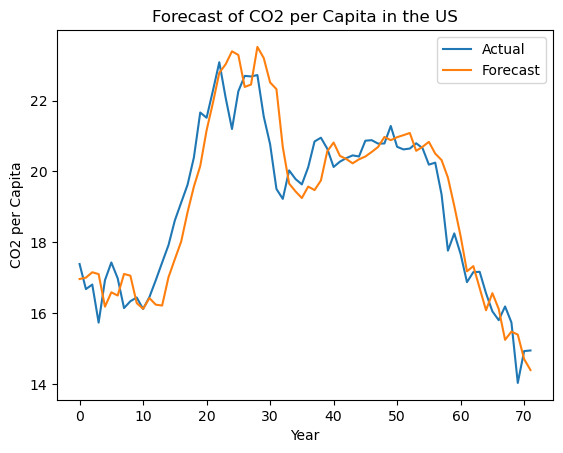

In [30]:
import matplotlib.pyplot as plt

plt.plot(us.index, us['CO2_per_capita'], label='Actual')
plt.plot(us['Forecast'], label='Forecast')

plt.xlabel('Year')
plt.ylabel('CO2 per Capita')
plt.title('Forecast of CO2 per Capita in the US')
plt.legend()
plt.show()

In [31]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Filter data for the United States
us = per_capita_filtered_notax[per_capita_filtered_notax["Country"] == 'United States']

# Reset index
us.reset_index(drop=True, inplace=True)

# Set frequency
us.index.freq = 'AS'

# Fit Simple Exponential Smoothing model
model = SimpleExpSmoothing(us['CO2_per_capita'])
fit_model = model.fit()

# Forecast for the next 10 years (2023-2032)
forecast = fit_model.forecast(steps=10)

print(forecast)


72    14.949616
73    14.949616
74    14.949616
75    14.949616
76    14.949616
77    14.949616
78    14.949616
79    14.949616
80    14.949616
81    14.949616
dtype: float64


# Conslusion: Simple Exponential Smoothing did not capture the variation in the data and returned same value for next 10 years. 
# Next Step: Try using Triple Exponential Smoothing


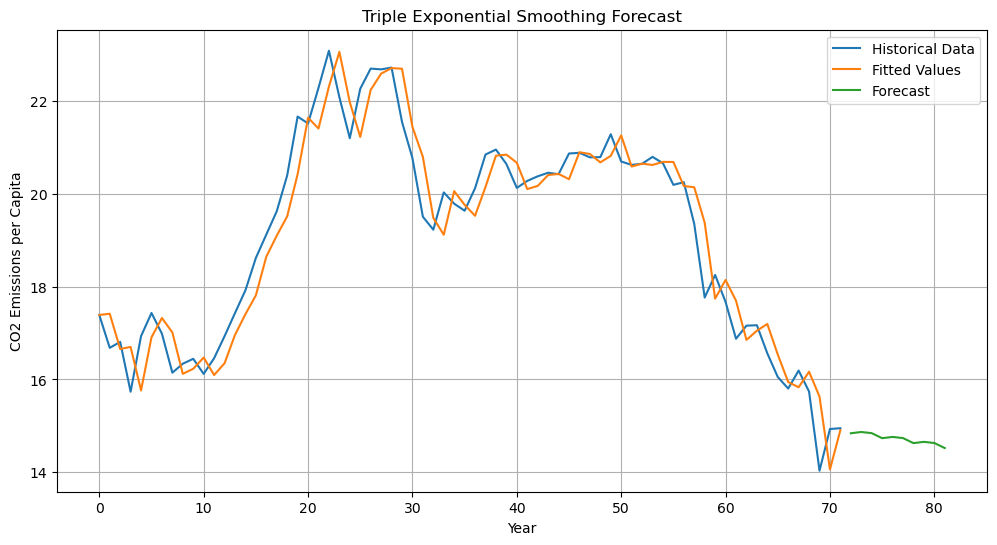

In [32]:
# Exponential Smoothing 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

us = us.dropna()

# Fit the Triple Exponential Smoothing model
model = ExponentialSmoothing(us['CO2_per_capita'], trend='add', seasonal='add', seasonal_periods=3)
fit = model.fit()

forecast = fit.forecast(10)

plt.figure(figsize=(12, 6))
plt.plot(us.index, us['CO2_per_capita'], label='Historical Data')
plt.plot(fit.fittedvalues.index, fit.fittedvalues, label='Fitted Values')
plt.plot(forecast.index, forecast, label='Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions per Capita')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
forecast

72    14.841055
73    14.868186
74    14.843458
75    14.734898
76    14.762028
77    14.737301
78    14.628740
79    14.655870
80    14.631143
81    14.522582
dtype: float64

# Next: Use SARIMAX model to forecast CO2 emissions with the presence of exogenous variable

In [34]:
# SARIMAX WITH EXOG VARS
import pandas as pd
import statsmodels.api as sm


carbon_tax_coefficient = [carbon_tax_coefficient] * len(us)  # Assuming it's a scalar, repeat for the length of the DataFrame
industrial_production = [Industrial_Production] * len(us)  # Assuming it's a scalar, repeat for the length of the DataFrame
energy_consumption = [Energy_Consumption] * len(us)  # Assuming it's a scalar, repeat for the length of the DataFrame


# Define the endogenous variable
endog = us['CO2_per_capita']

# Define the exogenous variables
exog = pd.DataFrame({
    'CarbonTaxDummy': carbon_tax_coefficient,
    'Industrial Production': Industrial_Production,
    'Energy Consumption': Energy_Consumption
})

# Fit the SARIMAX model
model = sm.tsa.SARIMAX(endog, exog=exog, order=(0, 1, 0))
results = model.fit()

# Get the coefficient of CarbonTaxDummy
carbon_tax_coefficient = results.params['CarbonTaxDummy']
print("Coefficient for CarbonTaxDummy:", carbon_tax_coefficient)

# Get the coefficient of Industrial Production
industrial_production_coefficient = results.params['Industrial Production']
print("Coefficient for Industrial Production:", industrial_production_coefficient)

# Get the coefficient of Energy Consumption
energy_consumption_coefficient = results.params['Energy Consumption']
print("Coefficient for Energy Consumption:", energy_consumption_coefficient)

# Define exogenous variables for the forecast period
exog_future = pd.DataFrame({
    'CarbonTaxDummy': [0] * 10,  # Assuming 0 for the forecast period
    'Industrial Production': [0] * 10,  # Assuming 0 for the forecast period
    'Energy Consumption': [0] * 10  # Assuming 0 for the forecast period
}, index=pd.date_range(start='2033-01-01', periods=10, freq='AS'))

# Forecast
forecast = results.forecast(steps=10, exog=exog_future)
print("Forecasted values:", forecast)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56952D+00    |proj g|=  1.81246D-01
  ys=-1.127E+00  -gs= 8.303E-01 BFGS update SKIPPED

At iterate    5    f=  9.53893D-01    |proj g|=  2.33291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     13      2     1     0   9.864D-07   9.539D-01
  F =  0.95389288377827242     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Coefficient for CarbonTaxDummy: -8.02537412765347e-12
Coefficient for Industrial

 This problem is unconstrained.


# Conclusion: SARIMAX did not capture the variation in the data and returned same value for next 10 years. 
# Next: Proceed to other model. 

# New Method

Train dataset:
- create a df containing all the datasets including countries with and without carbon tax implementation 

Test dataset: 
- create dummy values for other variables 
    - calculate the average increase in each variable and fill out the values for 2023-2032 

Scenario 1:

    - US with carbon tax dummy == 0 
    - predict the CO2 emissions for next 10 years

Scenario 2:

    - US without carbon tax dummy == 1
    - predict the CO2 emissions for next 10 years 
    
Compare Scenario 1 and Scenario 2 

In [71]:
# Train Data

train = pd.concat([per_capita_filtered_tax, per_capita_filtered_notax])
train = train.sort_values(by=['Country', 'Year'])

# Merge Control Variables 
train = pd.merge(train, gdp, on=['Country', 'Year'], how='inner')
#train = pd.merge(train, corp_investment, on=['Country', 'Year'], how='left')
#train = pd.merge(train, industrial_production, on=['Country', 'Year'], how='left')
#train = pd.merge(train, primary_energy_consumption, on=['Country', 'Year'], how='left')

countries_no_tax = ["United States", "China", "India", "Russia", "Brazil", "Germany", "South Korea", "Canada", "Australia", "Saudi Arabia", "Iran", "Indonesia", "South Africa", "Turkey", "Mexico", "Thailand", "Vietnam", "Malaysia", "Egypt", "United Arab Emirates"]

# Create 'CarbonTaxDummy' column
train['CarbonTaxDummy'] = train['Country'].apply(lambda x: 0 if x in countries_no_tax else 1)

train

,Country,Year,CO2_per_capita,GDP,CarbonTaxDummy
0,Argentina,1983,3.579042,3727.048010,1
1,Argentina,1984,3.568349,3787.470679,1
2,Argentina,1985,3.319273,2919.283511,1
3,Argentina,1986,3.387178,3454.296334,1
4,Argentina,1987,3.680022,3492.691474,1
...,...,...,...,...,...
2171,United States,2018,16.191355,62823.309438,0
2172,United States,2019,15.739861,65120.394663,0
2173,United States,2020,14.034053,63528.634303,0
2174,United States,2021,14.932488,70219.472454,0


In [72]:
# Test Data without Carbon Tax

test = pd.DataFrame({'Year': range(2012, 2033)})
test['Country'] = 'United States'

co2_per_capita_values = train[(train['Country'] == 'United States') & (train['Year'] >= 2012) & (train['Year'] <= 2022)]['CO2_per_capita'].values

test.loc[test['Year'] <= 2022, 'CO2_per_capita'] = co2_per_capita_values

gdp_values = train[(train['Country'] == 'United States') & (train['Year'] >= 2012) & (train['Year'] <= 2022)]['GDP'].values

test.loc[test['Year'] <= 2022, 'GDP'] = gdp_values

test['CarbonTaxDummy'] = 0
test

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2012,United States,16.876879,51784.418574,0
1,2013,United States,17.158995,53291.127689,0
2,2014,United States,17.168007,55123.849787,0
3,2015,United States,16.562983,56762.729452,0
4,2016,United States,16.053692,57866.744934,0
5,2017,United States,15.804429,59907.754261,0
6,2018,United States,16.191355,62823.309438,0
7,2019,United States,15.739861,65120.394663,0
8,2020,United States,14.034053,63528.634303,0
9,2021,United States,14.932488,70219.472454,0


In [73]:
# Calculate the average annual increase in GDP

gdp_diff = train.loc[train['Country'] == 'United States', 'GDP'].diff().mean()

if not train.empty:
    # Get the GDP value for the last available year in the train DataFrame for the United States
    last_year_gdp = train.loc[train['Country'] == 'United States', 'GDP'].max()

    # Calculate the GDP values for the years 2023 to 2032 based on the average increase
    test.loc[test['Year'] >= 2023, 'GDP'] = last_year_gdp + gdp_diff * (test['Year'] - train['Year'].max())

else:
    print("No data available for the United States in the train DataFrame.")

test

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2012,United States,16.876879,51784.418574,0
1,2013,United States,17.158995,53291.127689,0
2,2014,United States,17.168007,55123.849787,0
3,2015,United States,16.562983,56762.729452,0
4,2016,United States,16.053692,57866.744934,0
5,2017,United States,15.804429,59907.754261,0
6,2018,United States,16.191355,62823.309438,0
7,2019,United States,15.739861,65120.394663,0
8,2020,United States,14.034053,63528.634303,0
9,2021,United States,14.932488,70219.472454,0


In [74]:
# Test Data with Carbon Tax

test2 = pd.DataFrame({'Year': range(2012, 2033)})
test2['Country'] = 'United States'

co2_per_capita_values = train[(train['Country'] == 'United States') & (train['Year'] >= 2012) & (train['Year'] <= 2022)]['CO2_per_capita'].values

test2.loc[test2['Year'] <= 2022, 'CO2_per_capita'] = co2_per_capita_values

gdp_values = train[(train['Country'] == 'United States') & (train['Year'] >= 2012) & (train['Year'] <= 2022)]['GDP'].values

test2.loc[test2['Year'] <= 2022, 'GDP'] = gdp_values

test2['CarbonTaxDummy'] = 1
test2

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2012,United States,16.876879,51784.418574,1
1,2013,United States,17.158995,53291.127689,1
2,2014,United States,17.168007,55123.849787,1
3,2015,United States,16.562983,56762.729452,1
4,2016,United States,16.053692,57866.744934,1
5,2017,United States,15.804429,59907.754261,1
6,2018,United States,16.191355,62823.309438,1
7,2019,United States,15.739861,65120.394663,1
8,2020,United States,14.034053,63528.634303,1
9,2021,United States,14.932488,70219.472454,1


In [75]:
# Calculate the average annual increase in GDP

gdp_diff = train.loc[train['Country'] == 'United States', 'GDP'].diff().mean()

if not train.empty:
    # Get the GDP value for the last available year in the train DataFrame for the United States
    last_year_gdp = train.loc[train['Country'] == 'United States', 'GDP'].max()

    # Calculate the GDP values for the years 2023 to 2032 based on the average increase
    test2.loc[test2['Year'] >= 2023, 'GDP'] = last_year_gdp + gdp_diff * (test2['Year'] - train['Year'].max())

else:
    print("No data available for the United States in the train DataFrame.")

test2

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy
0,2012,United States,16.876879,51784.418574,1
1,2013,United States,17.158995,53291.127689,1
2,2014,United States,17.168007,55123.849787,1
3,2015,United States,16.562983,56762.729452,1
4,2016,United States,16.053692,57866.744934,1
5,2017,United States,15.804429,59907.754261,1
6,2018,United States,16.191355,62823.309438,1
7,2019,United States,15.739861,65120.394663,1
8,2020,United States,14.034053,63528.634303,1
9,2021,United States,14.932488,70219.472454,1


# SARIMAX Modeling

In [36]:
# Checking Stationarity of my data using Augmented Dickey-Fuller Test
# If p-value is low (0.05), we assume the dataset is stationary

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [37]:
adf_test(train['CO2_per_capita'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -5.522722
p-value                    0.000002
# lags used               18.000000
# observations          2157.000000
critical value (1%)       -3.433385
critical value (5%)       -2.862881
critical value (10%)      -2.567484
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

auto_arima(train['CO2_per_capita'], error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2176
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -4432.702
Date:                Wed, 13 Mar 2024   AIC                           8873.404
Time:                        23:18:32   BIC                           8896.143
Sample:                             0   HQIC                          8881.718
                               - 2176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6856      0.048    -14.392      0.000      -0.779      -0.592
ar.L2         -0.0450      0.013     -3.500      0.000      -0.070      -0.020
ma.L1          0.7256      0.046     15.635      0.000       0.635       0.817
sigma2         3.4492      0.008    440.263      0.000       3.434       3.465
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          12769869.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.62   Skew:                            12.60
Prob(H) (two-sided):                  0.00   Kurtosis:                       377.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecast

In [76]:
# Forecasting using Test Data without Carbon Tax
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model using all the training data
model = SARIMAX(train['CO2_per_capita'], exog=train['GDP'], order=(2, 1, 1))

# Increase maxiter and fit the model

# Predict CO2_per_capita for the test data
predicted_values = fitted_model.predict(start=test.index.min(), end=test.index.max(),
                                        exog=test['GDP'].values.reshape(-1, 1))

# Add predicted values to the test DataFrame
test['CO2_per_capita_predicted'] = predicted_values
test

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy,CO2_per_capita_predicted
0,2012,United States,16.876879,51784.418574,0,-0.007315
1,2013,United States,17.158995,53291.127689,0,3.578924
2,2014,United States,17.168007,55123.849787,0,3.569725
3,2015,United States,16.562983,56762.729452,0,3.310645
4,2016,United States,16.053692,57866.744934,0,3.405261
5,2017,United States,15.804429,59907.754261,0,3.678315
6,2018,United States,16.191355,62823.309438,0,3.824849
7,2019,United States,15.739861,65120.394663,0,3.623470
8,2020,United States,14.034053,63528.634303,0,3.438626
9,2021,United States,14.932488,70219.472454,0,3.558535


In [77]:
# Forecasting using Test Data with Carbon Tax Dummy

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX model using all the training data
model = SARIMAX(train['CO2_per_capita'], exog=train['GDP'], order=(2, 1, 1))

# Increase maxiter and fit the model

# Predict CO2_per_capita for the test data
predicted_values = fitted_model.predict(start=test2.index.min(), end=test2.index.max(),
                                        exog=test2['GDP'].values.reshape(-1, 1))

# Add predicted values to the test DataFrame
test2['CO2_per_capita_predicted'] = predicted_values
test2

,Year,Country,CO2_per_capita,GDP,CarbonTaxDummy,CO2_per_capita_predicted
0,2012,United States,16.876879,51784.418574,1,-0.007315
1,2013,United States,17.158995,53291.127689,1,3.578924
2,2014,United States,17.168007,55123.849787,1,3.569725
3,2015,United States,16.562983,56762.729452,1,3.310645
4,2016,United States,16.053692,57866.744934,1,3.405261
5,2017,United States,15.804429,59907.754261,1,3.678315
6,2018,United States,16.191355,62823.309438,1,3.824849
7,2019,United States,15.739861,65120.394663,1,3.623470
8,2020,United States,14.034053,63528.634303,1,3.438626
9,2021,United States,14.932488,70219.472454,1,3.558535


# Problem: Predicted CO2 emissions is not reasonable.
# Next Step:

    - seek help from Penn State Statistics Consulting Center
    - try using other forecasting model

In [ ]:
# LSTM Model 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaler = MinMaxScaler()
train[['CO2_per_capita', 'GDP']] = scaler.fit_transform(train[['CO2_per_capita', 'GDP']])

X = train[['GDP', 'CarbonTaxDummy']].values
y = train['CO2_per_capita'].values

X = X.reshape((X.shape[0], 1, X.shape[1]))

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(1, 2)))
model.add(Dense(units=1))  # Adjust units to match the number of output features
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=100, batch_size=1, verbose=2)

X_test = test[['GDP', 'CarbonTaxDummy']].values
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
predicted_values = model.predict(X_test)

predicted_values = scaler.inverse_transform(predicted_values)

test['CO2_per_capita_predicted'] = predicted_values

print(test[['Year', 'Country', 'CO2_per_capita_predicted']])

# ValueError: non-broadcastable output operand with shape (21,1) doesn't match the broadcast shape (21,2)